In [3]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import random
import tensorflow as tf

### 1. Image Augmentation

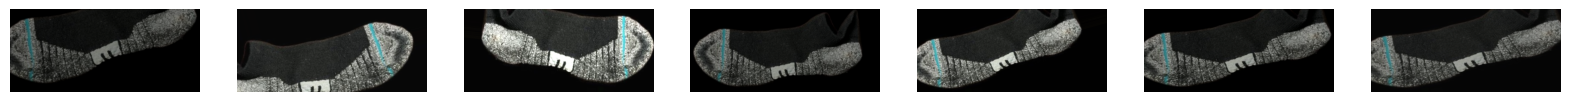

In [4]:
# TODO: Maybe remove rotation later
# TODO: Maybe remove horizontal flip later

np_img = np.array(Image.open("../1Data-Collection/Manual/Centered/IMG_0555.jpg"))
np_img = np_img.reshape(1, np_img.shape[0], np_img.shape[1], np_img.shape[2])

# Augumentation Configuration
roating_range = 20
# width_shift_range = 0.05
# height_shift_range = 0.05
width_shift_range = 0
height_shift_range = 0
brightness_range = [0.5, 1.3]
shear_range = 0
zoom_range = 0.15
channel_shift_range = 10
horizontal_flip = True
vertical_flip = False

datagen = ImageDataGenerator(rotation_range=roating_range, width_shift_range=width_shift_range, height_shift_range=height_shift_range, brightness_range=brightness_range, shear_range=shear_range, zoom_range=zoom_range, channel_shift_range=channel_shift_range, horizontal_flip=horizontal_flip, vertical_flip=vertical_flip)

aug_iter = datagen.flow(np_img, batch_size=1)

# Show augmented images variation
plt.figure(figsize=(20, 20))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.axis("off")
    plt.imshow(aug_iter.next().squeeze().astype(np.uint8))  



In [5]:
def generateAugumentedImages(img, imageCnt = 100):
    aug_iter = datagen.flow(img, batch_size=1)
    images = []

    for i in range(imageCnt):
        images.append(aug_iter.next().astype(np.uint8))
    return np.array(images)

### 2. Prepare the data

In [6]:
def load_images(shape, seed=1234, dataDir="../1Data-Collection/Manual/Centered/"):
  # Get all images
  random.seed(seed)

  images = os.listdir(dataDir)
  random.shuffle(images)
  images = [dataDir + i for i in images]

  # Load to numpy array
  np_images = []
  for i in tqdm(images):
      np_images.append(np.array(Image.open(i).resize(shape)))

  np_images = np.array(np_images).astype(np.float32)

  return np_images

### 3. Transfer Learning

In [7]:
def featureExtractor(model, shape, augCnt, preprocess_input, dataDir="../1Data-Collection/Manual/Centered/"):
  # Load images
  print("\nLoading Images...")
  np_img = load_images(shape, dataDir)

  # Augumentation
  print ("\nAugmenting Images...")
  aug_imgs = []
  for i in tqdm(range(np_img.shape[0])):
    aug_imgs.append(generateAugumentedImages(np.expand_dims(np_img[i], axis=0), augCnt))
  aug_imgs = np.array(aug_imgs)

  print("Augmented Images Shape:", aug_imgs.shape)

  # Preprocess
  preprocess_input = preprocess_input(aug_imgs)

  # Extract features
  print("\nExtracting Features...")
  features = []
  for i in tqdm(range(aug_imgs.shape[0])):
    features.append(model.predict(preprocess_input[i].squeeze(), verbose=0))
    
  features = np.array(features)
  print("Features Shape:", features.shape)

  return features, aug_imgs

### 4. Preparing the extracted features and labels

In [8]:
def split_data(features, aug_imgs, split_ratio=0.8, seed=1234):
  # Split data
  random.seed(seed)
  randomize = np.arange(features.shape[0])
  random.shuffle(randomize)

  features = features[randomize]
  aug_imgs = aug_imgs[randomize]

  trainCnt = int(features.shape[0] * split_ratio)
  train_features = features[:trainCnt]
  train_imgs = aug_imgs[:trainCnt]

  test_features = features[trainCnt:]
  test_imgs = aug_imgs[trainCnt:]

  return train_features, train_imgs, test_features, test_imgs


In [9]:
# This function take either train or test data and generate pairs and non-pairs
# TODO: This could be super memory intensive. Maybe we should generate pairs/non-pairs on the fly?
def getTrainTest(data, imgs, type, seed=1234):
  X = []
  y = []

  pairImages = []
  imgCnt = 100

  number_of_pairs = 0

  # Generating Pairs
  print("\nGenerating Pairs...")
  for i in tqdm(range(data.shape[0])): # For each socks
    for j in range(data.shape[1]): # For each augumented images
      for k in range(data.shape[1]): # For each other augumented images
        if j != k:
          X.append([data[i][j], data[i][k]])
          y.append(1)
          number_of_pairs += 1

          if number_of_pairs <= imgCnt:
            img1 = (imgs[i][j].squeeze()).astype(np.uint8)
            img2 = (imgs[i][k].squeeze()).astype(np.uint8)

            # join images sizeways to one image
            img = np.concatenate((img1, img2), axis=1)

            pairImages.append(img)


  # Load images to tensorboard
  with tf.summary.create_file_writer(f"../2PreparingData/logs/{type}/pair/").as_default():
    tf.summary.image("Pair", np.array(pairImages), max_outputs=100, step=0)

  
  nonPair_X = []

  # Generating Non-Pairs
  print(f"\nGenerating {number_of_pairs} Non-Pairs...")

  number_of_non_pairs = 0
  random.seed(seed)

  while number_of_non_pairs != number_of_pairs:
    sock1, sock2 = random.sample(range(data.shape[0]), 2)
    img1, img2 = random.sample(range(data.shape[1]), 2)

    X.append([data[sock1][img1], data[sock2][img2]])
    y.append(0)
    number_of_non_pairs += 1

    if number_of_non_pairs <= imgCnt:
      img1 = (imgs[sock1][img1].squeeze()).astype(np.uint8)
      img2 = (imgs[sock2][img2].squeeze()).astype(np.uint8)

      # join images sizeways to one image
      img = np.concatenate((img1, img2), axis=1)

      nonPair_X.append(img)
      
  # Load images to tensorboard
  with tf.summary.create_file_writer(f"../2PreparingData/logs/{type}/nonpair/").as_default():
    tf.summary.image("Non-Pair", np.array(nonPair_X), max_outputs=100, step=0)

  X = np.array(X)
  y = np.array(y)

  return X, y

### 5. Use pre-trained model as a feature extractor

In [10]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

# Load MobileNetV2
# mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

In [11]:
features, aug_imgs = featureExtractor(vgg16, (224, 224), 7, preprocess_input)


Loading Images...


100%|██████████| 109/109 [00:00<00:00, 215.01it/s]



Augmenting Images...


100%|██████████| 109/109 [00:16<00:00,  6.60it/s]


Augmented Images Shape: (109, 7, 1, 224, 224, 3)

Extracting Features...


100%|██████████| 109/109 [04:21<00:00,  2.40s/it]

Features Shape: (109, 7, 512)


In [13]:
train, trainImg, test, testImg = split_data(features, aug_imgs)
train_X, train_y = getTrainTest(train, trainImg, "train")
test_X, test_y = getTrainTest(test, testImg, "test")

print("Train X Shape:", train_X.shape)
print("Train y Shape:", train_y.shape)
print("Test X Shape:", test_X.shape)
print("Test y Shape:", test_y.shape)


Generating Pairs...


  0%|          | 0/87 [00:00<?, ?it/s]

100%|██████████| 87/87 [00:00<00:00, 2826.13it/s]



Generating 3654 Non-Pairs...

Generating Pairs...


100%|██████████| 22/22 [00:00<00:00, 905.49it/s]



Generating 924 Non-Pairs...
Train X Shape: (7308, 2, 512)
Train y Shape: (7308,)
Test X Shape: (1848, 2, 512)
Test y Shape: (1848,)


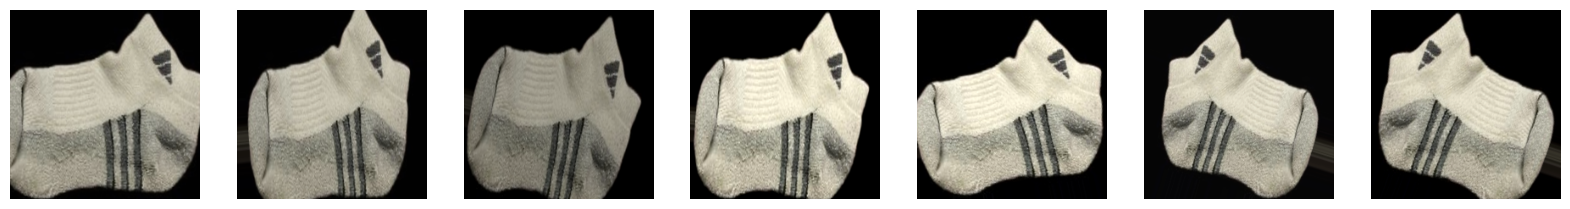

In [14]:
imgSelected = aug_imgs[2]

# visualize the image

plt.figure(figsize=(20, 20))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.axis("off")
    plt.imshow((imgSelected[i].squeeze()).astype(np.uint8))

### 6. Export data to npy files

In [14]:
np.save("../3ModelTraining/train_X.npy", train_X)
np.save("../3ModelTraining/train_y.npy", train_y)
np.save("../3ModelTraining/test_X.npy", test_X)
np.save("../3ModelTraining/test_y.npy", test_y)